# Data Preparation

In this notebook, the downloaded data is inspected during an exploratory data
analysis (EDA). Subsequently, it is prepared so it can be used for training a 
machine learning model.

Potentially, useful parts of several data sets will be integrated here.

The model is supposed to be usable as a service as opposed to a pure research
project, since one of the requirements of this exercise is to deploy it.
Because of that, I want the features to be activels choosable by the users.
However, specific features related to demographics or health such as age or sex
may also have an influence on sleep quality, and must be considered as well.

The goal of this project is to provide a service allowing a user to submit
information about their demographics, health and daily activities and receive a
prediction of the quality of their sleep for the coming night based on
influencable decisions.

Factors like fraction of light or REM sleep are not direct choices by the users,
but typically rather outcomes or consequences of their decisions in a similar
manner as the sleep quality itself. Because of that, they will not be considered
features in this project.

In contrast, factors like daily consumption of caffeine, nicotine, alcohol or
levels of physical activity and study or work typically vary on a day to day 
basis and are more directly subjected to individual decisions made by the users.
Because of that, these variables are of interest in this project, and will be
considered features.

On top of that, features ideally need to be relevant to a large fraction of
users. For example, one of the data sets has a feature `University_Year`.
I still need to decide if I will consider this, as not all users may be students
. In contrast to that, `Study_Hours` may be considered of similar of equal
nature as general work hours, and screen times should apply to close to all
users as well.

Disclaimer: Unfortunately, all the available data sets are synthetically
generated and may not necessarily reflect true causes or patterns in sleep
quality.


# FIXME
- rewrite the text a little so it describes what happens here more accurately
- I use more than one data set here, because I only found very small ones.
Because of that, I integrate them. The way I approach this is by first doing a
tiny first EDA for identifying suitable features, handling missing values etc.
I do this for every data set, and choose one that's going to server as the main
data set based on which one has the most usable features for my use case (see
above).
- After selecting a main data set, I take care of that one first. I perform a
more extensive EDA on it, and prepare it for analysis.
- Next, I perform the same data transformations to the additional data sets, and
integrate them.
- Finally, I perform an EDA on the integrated data set.

## Preparations

In [1]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

from sklearn.impute import KNNImputer
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# paths
PATH_DATA_DIR = Path("../data/raw")
PATH_DATA_INTERMEDIATE_DIR = Path("../data/intermediate")
PATH_DATA_PROCESSED_DIR = Path("../data/processed")
PATH_DATA_MAIN_PROCESSED_DIR = PATH_DATA_PROCESSED_DIR / "main"
PATH_STUDENT_SLEEP_PATTERNS = PATH_DATA_DIR / "student_sleep_patterns.csv"
PATH_WEARABLE_TECH_SLEEP_QUALITY = PATH_DATA_DIR / "wearable_tech_sleep_quality_1.csv"
PATH_SLEEP_EFFICIENCY = PATH_DATA_DIR / "Sleep_Efficiency.csv"
PATH_SLEEP_HEALTH_AND_LIFESTYLE = PATH_DATA_DIR / "Sleep_health_and_lifestyle_dataset.csv"

In [2]:
# functions

def read_csv_cols_lower_underscore(path: Path) -> pd.DataFrame:
    """Read a CSV file and return a DataFrame with column names in lowercase
    and whitespace characters replaced by underscores.
    
    Args:
        path (Path): Path to the CSV file.
    
    Returns:
        pd.DataFrame: DataFrame with column names in lowercase and whitespace
        characters replaced by underscores.
    """
    df = pd.read_csv(path)
    df.columns = df.columns.str.lower()
    df.columns = df.columns.str.replace(" ", "_")
    return df

def split_write_data(data: pd.DataFrame,
                     label_column: str,
                     output_dir: Path,
                     filename_prefix: str,
                     random_state: int = 1337):
    """
    Split the feature and label data sets into train and test sets and
    save them to the processed data directory.
    Proportions are 80:20 for train:test.
    Val set is not used here, because models are tuned using cross validation.
    
    Args:
        data (pd.DataFrame): Data set to split.
        label_column (str): Name of the label column.
        output_dir (Path): Path to the output directory.
        filename_prefix (str): Prefix for the filenames.
        random_state (int): Random state for the split.
        
    Returns:
        Nothing. Writes the train and test sets to the processed data
        directory.
    """
    
    # get feature and label data set
    X = data.drop(columns=[label_column])
    y = data[label_column]
    
    # make train test split of proportion 80:20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # create directory if it does not exist yet
    os.makedirs(output_dir, exist_ok=True)
    
    # save the train, and test feature sets
    X_train.to_csv(output_dir / f"{filename_prefix}_train_features.csv", index=False)
    X_test.to_csv(output_dir / f"{filename_prefix}_test_features.csv", index=False)
    
    # save the train and test labels
    y_train.to_csv(output_dir / f"{filename_prefix}_train_labels.csv", index=False)
    y_test.to_csv(output_dir / f"{filename_prefix}_test_labels.csv", index=False)
    
def transform_dataset(data: pd.DataFrame, label_col: str) -> pd.DataFrame:
    """
    Transform dataset to match main dataset transformations:
    - One hot encode categorical columns
    - Minmax scale numerical columns
    - Ensure label column is at the end
    
    Args:
        data (pd.DataFrame): Input dataframe.
        label_col (str): Name of the label/target column.
    
    Returns:
        data_scaled (pd.DataFrame): Transformed dataframe.
    """
    
    # get label values before transformation
    label_values = data[label_col].copy()
    
    # drop label temporarily
    data = data.drop(columns=[label_col])
    
    # identify categorical columns (object dtype)
    cat_cols = data.select_dtypes(include=["object"]).columns
    
    # one hot encode categorical columns
    if len(cat_cols) > 0:
        data = pd.get_dummies(data, columns=cat_cols)
    
    # minmax scale all columns
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(
        scaler.fit_transform(data),
        columns=data.columns,
        index=data.index
    )
    
    # scale label column separately
    label_scaled = MinMaxScaler().fit_transform(label_values.values.reshape(-1, 1))
    
    # add scaled label back as last column
    data_scaled[label_col] = label_scaled
    
    return data_scaled

## Data set: `student_sleep_patterns.csv`

### Exploratory Data Analysis

In [3]:
# load data set into pandas data frame
df_student_sleep_patterns = read_csv_cols_lower_underscore(PATH_STUDENT_SLEEP_PATTERNS)

df_student_sleep_patterns

,student_id,age,gender,university_year,sleep_duration,study_hours,screen_time,caffeine_intake,physical_activity,sleep_quality,weekday_sleep_start,weekend_sleep_start,weekday_sleep_end,weekend_sleep_end
0,1,24,Other,2nd Year,7.7,7.9,3.4,2,37,10,14.16,4.05,7.41,7.06
1,2,21,Male,1st Year,6.3,6.0,1.9,5,74,2,8.73,7.10,8.21,10.21
2,3,22,Male,4th Year,5.1,6.7,3.9,5,53,5,20.00,20.47,6.88,10.92
3,4,24,Other,4th Year,6.3,8.6,2.8,4,55,9,19.82,4.08,6.69,9.42
4,5,20,Male,4th Year,4.7,2.7,2.7,0,85,3,20.98,6.12,8.98,9.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,496,24,Male,2nd Year,5.1,9.3,1.9,4,110,4,17.42,8.43,6.93,10.78
496,497,20,Male,2nd Year,8.9,7.7,3.5,3,40,4,1.22,15.54,5.85,7.23
497,498,21,Male,3rd Year,5.7,6.4,3.9,1,68,10,9.94,2.25,5.46,10.72
498,499,18,Female,2nd Year,4.9,0.5,3.5,0,12,2,19.10,15.49,8.35,7.20


### Suitable Features

These features match the criteria, because they can easily be influenced or 
may have an influence on sleep quality and are not outcomes themselves.

- age
- gender
- university_year
- study_hours
- screen_time
- caffeine_intake
- physical_activity
- weekday_sleep_start
- weekend_sleep_start
- weekday_sleep_end
- weekend_sleep_end

Explanation for sleep start and end features: These are the times the student
**typically** goes to sleep. They may represent some habits. It may have an
influence on the quality of your sleep if you stick to them.

### Label

This is the characteristic to predict based on the features.

- sleep_quality

### Unsuitable Features

While some of these features may indeed influence the quality of sleep, they
are not decisions one can always make **before** going to bed.

- student_id: No information about sleep. It's often good practice to still keep
IDs during data processing and dropping them just before training. I will
remove them right here though, because all the data sets are synthetic anyway
and the IDs are ascending numbers. Beyond the fact that they don't provide any
insight, they won't be unique after joining the data sets.

- sleep_duration: If you have deep sleep, you may decide for how long you will
stay in bed, but if your sleep is bad, you may not be able to influence this at
all. In fact it is often the opposite. Potential users may be enriched in people
having sleep problems. They will try to improve sleep quality and get a full
night of rest. Many people cannot just decide to sleep for x amount of hours.

In [4]:
# select relevant features
df_student_sleep_patterns_selected = df_student_sleep_patterns[
    [
        "age",
        "gender",
        "university_year",
        "study_hours",
        "screen_time",
        "caffeine_intake",
        "physical_activity",
        "weekday_sleep_start",
        "weekend_sleep_start",
        "weekday_sleep_end",
        "weekend_sleep_end",
        "sleep_quality",
    ]
]

df_student_sleep_patterns_selected

,age,gender,university_year,study_hours,screen_time,caffeine_intake,physical_activity,weekday_sleep_start,weekend_sleep_start,weekday_sleep_end,weekend_sleep_end,sleep_quality
0,24,Other,2nd Year,7.9,3.4,2,37,14.16,4.05,7.41,7.06,10
1,21,Male,1st Year,6.0,1.9,5,74,8.73,7.10,8.21,10.21,2
2,22,Male,4th Year,6.7,3.9,5,53,20.00,20.47,6.88,10.92,5
3,24,Other,4th Year,8.6,2.8,4,55,19.82,4.08,6.69,9.42,9
4,20,Male,4th Year,2.7,2.7,0,85,20.98,6.12,8.98,9.01,3
...,...,...,...,...,...,...,...,...,...,...,...,...
495,24,Male,2nd Year,9.3,1.9,4,110,17.42,8.43,6.93,10.78,4
496,20,Male,2nd Year,7.7,3.5,3,40,1.22,15.54,5.85,7.23,4
497,21,Male,3rd Year,6.4,3.9,1,68,9.94,2.25,5.46,10.72,10
498,18,Female,2nd Year,0.5,3.5,0,12,19.10,15.49,8.35,7.20,2


In [5]:
# replace white spaces by underscores in the university_year column
df_student_sleep_patterns_selected.loc[:, "university_year"] = df_student_sleep_patterns_selected["university_year"].str.replace(" ", "_")

# make gender column lowercase
df_student_sleep_patterns_selected.loc[:, "gender"] = df_student_sleep_patterns_selected["gender"].str.lower()

df_student_sleep_patterns_selected

,age,gender,university_year,study_hours,screen_time,caffeine_intake,physical_activity,weekday_sleep_start,weekend_sleep_start,weekday_sleep_end,weekend_sleep_end,sleep_quality
0,24,other,2nd_Year,7.9,3.4,2,37,14.16,4.05,7.41,7.06,10
1,21,male,1st_Year,6.0,1.9,5,74,8.73,7.10,8.21,10.21,2
2,22,male,4th_Year,6.7,3.9,5,53,20.00,20.47,6.88,10.92,5
3,24,other,4th_Year,8.6,2.8,4,55,19.82,4.08,6.69,9.42,9
4,20,male,4th_Year,2.7,2.7,0,85,20.98,6.12,8.98,9.01,3
...,...,...,...,...,...,...,...,...,...,...,...,...
495,24,male,2nd_Year,9.3,1.9,4,110,17.42,8.43,6.93,10.78,4
496,20,male,2nd_Year,7.7,3.5,3,40,1.22,15.54,5.85,7.23,4
497,21,male,3rd_Year,6.4,3.9,1,68,9.94,2.25,5.46,10.72,10
498,18,female,2nd_Year,0.5,3.5,0,12,19.10,15.49,8.35,7.20,2


The columns `weekday_sleep_start`,
`weekday_sleep_end`, `weekend_sleep_start` and `weekend_sleep_end` will have to
be processed a little further.
While querying the model, it will be hard to distinguish between weekday and
weekend.
I'd have to ask the user or use system time.
And even then, there is no feature containing information about the current day
of the week.
I cannot add it, because I don't know the day the data has been "recorded"
(I mean it's synthetic anyway, but let's pretend).

Also, while selecting the data sets, I saw that these columns have no real
equivalents in two of the other data sets.
In `df_sleep_efficiency_selected`, there is an equivalent, but it does not
So, they will be averaged.
Since there are five week days, and two days of weekend, a weighted average will
be calculated.

In [6]:
# weighted average of bed and wake up time
bedtime = (5 * df_student_sleep_patterns_selected["weekday_sleep_start"] + 2 * df_student_sleep_patterns_selected["weekend_sleep_start"]) / 7
wakeup_time = (5 * df_student_sleep_patterns_selected["weekday_sleep_end"] + 2 * df_student_sleep_patterns_selected["weekend_sleep_end"]) / 7

# get position to insert new columns
insert_position = df_student_sleep_patterns_selected.columns.get_loc("weekday_sleep_start")

# insert new columns
df_student_sleep_patterns_selected.insert(insert_position, "bedtime", bedtime)
df_student_sleep_patterns_selected.insert(insert_position + 1, "wakeup_time", wakeup_time)

# drop the old columns
df_student_sleep_patterns_selected = df_student_sleep_patterns_selected.drop(columns=["weekday_sleep_start", "weekend_sleep_start", "weekday_sleep_end", "weekend_sleep_end"])

df_student_sleep_patterns_selected

,age,gender,university_year,study_hours,screen_time,caffeine_intake,physical_activity,bedtime,wakeup_time,sleep_quality
0,24,other,2nd_Year,7.9,3.4,2,37,11.271429,7.310000,10
1,21,male,1st_Year,6.0,1.9,5,74,8.264286,8.781429,2
2,22,male,4th_Year,6.7,3.9,5,53,20.134286,8.034286,5
3,24,other,4th_Year,8.6,2.8,4,55,15.322857,7.470000,9
4,20,male,4th_Year,2.7,2.7,0,85,16.734286,8.988571,3
...,...,...,...,...,...,...,...,...,...,...
495,24,male,2nd_Year,9.3,1.9,4,110,14.851429,8.030000,4
496,20,male,2nd_Year,7.7,3.5,3,40,5.311429,6.244286,4
497,21,male,3rd_Year,6.4,3.9,1,68,7.742857,6.962857,10
498,18,female,2nd_Year,0.5,3.5,0,12,18.068571,8.021429,2


### This will be used as the main data set here

The data set has 500 rows and 11 meaningful features.
**This can serve as the main data set for this project.**
500 rows is far from a lot, but from what I have found, this is the most
useful data set.
To make up for the low number of rows / examples, I will try integrating further
data sets.
If that does not turn out to work well, I will just use this main data set only.

In [7]:
# check if the data sets has any missing values
df_student_sleep_patterns_selected.isnull().sum()

age                  0
gender               0
university_year      0
study_hours          0
screen_time          0
caffeine_intake      0
physical_activity    0
bedtime              0
wakeup_time          0
sleep_quality        0
dtype: int64

There are no missing values.

## Data set: `wearable_tech_sleep_quality_1.csv`

### Exploratory Data Analysis

In [8]:
# load the data set into a pandas data frame
df_wearable_tech_sleep_quality = read_csv_cols_lower_underscore(PATH_WEARABLE_TECH_SLEEP_QUALITY)

df_wearable_tech_sleep_quality

,heart_rate_variability,body_temperature,movement_during_sleep,sleep_duration_hours,sleep_quality_score,caffeine_intake_mg,stress_level,bedtime_consistency,light_exposure_hours
0,79.934283,37.199678,1.324822,4.638289,1.000000,107.624032,2.771837,0.657037,7.933949
1,67.234714,36.962317,1.855481,6.209422,1.000000,104.658589,3.738138,0.144464,6.992699
2,82.953771,36.529815,1.207580,6.879592,10.000000,0.000000,3.115880,0.642949,7.655250
3,100.460597,36.176532,1.692038,10.331531,1.000000,116.990981,3.904008,0.453255,9.429463
4,65.316933,36.849112,0.106385,8.334830,1.000000,223.282908,4.571699,0.641492,10.555713
...,...,...,...,...,...,...,...,...,...
995,64.377994,37.035075,2.077481,7.542686,1.000000,167.146932,4.404266,0.941971,8.203260
996,105.953731,36.486739,2.257753,4.383282,1.000000,265.264810,6.538063,0.565399,10.334435
997,82.816857,36.059063,0.758239,7.019553,8.445252,28.259621,3.945222,0.332975,11.176894
998,58.576420,36.418467,2.334176,9.965067,1.000000,196.795042,4.989787,0.830583,6.630026


### Suitable Features

- caffeine_intake_mg
- stress_level
- light_exposure_hours

### Label

- sleep_quality_score

### Unsuitable Features

Cannot always be decided by user:
- heart_rate_variability
- body_temperature
- movement_during_sleep
- sleep_duration_hours

Hard to integrate with other data sets:

- bedtime_consistency

In [9]:
# select releant columns
df_wearable_tech_sleep_quality_selected = df_wearable_tech_sleep_quality[
    [
        "caffeine_intake_mg",
        "stress_level",
        "light_exposure_hours",
        "sleep_quality_score"
    ]
]

df_wearable_tech_sleep_quality_selected

,caffeine_intake_mg,stress_level,light_exposure_hours,sleep_quality_score
0,107.624032,2.771837,7.933949,1.000000
1,104.658589,3.738138,6.992699,1.000000
2,0.000000,3.115880,7.655250,10.000000
3,116.990981,3.904008,9.429463,1.000000
4,223.282908,4.571699,10.555713,1.000000
...,...,...,...,...
995,167.146932,4.404266,8.203260,1.000000
996,265.264810,6.538063,10.334435,1.000000
997,28.259621,3.945222,11.176894,8.445252
998,196.795042,4.989787,6.630026,1.000000


In [10]:
# check if the data sets has any missing values
df_wearable_tech_sleep_quality_selected.isnull().sum()

caffeine_intake_mg      0
stress_level            0
light_exposure_hours    0
sleep_quality_score     0
dtype: int64

There are no missing values.

Some of these columns such as caffeine intake [mg] match with the main data set.
Others don't.
If I join / integrate them, I will have to scale the sleep quality score so the
scores from different data sets have a comparable interval.
One option would be normalizing and standardizing them.

This dataset is not bad, but it cannot serve as standalone data for the current
project, so I won't save it to an individual file.

## Data set: `Sleep_Efficiency.csv`

### Exploratory Data Analysis

In [11]:
# load the data set into a pandas data frame
df_sleep_efficiency = read_csv_cols_lower_underscore(PATH_SLEEP_EFFICIENCY)

df_sleep_efficiency.head()

,id,age,gender,bedtime,wakeup_time,sleep_duration,sleep_efficiency,rem_sleep_percentage,deep_sleep_percentage,light_sleep_percentage,awakenings,caffeine_consumption,alcohol_consumption,smoking_status,exercise_frequency
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0


Features and label are selected as defined previously.

### Suitable Features

- age
- gender
- caffeine_consumption
- alcohol_consumption
- smoking_status
- exercise_frequency
- bedtime: indicates when each subject goes to bed each day -> similar to main data
- wakeup_time: indicates when each subject wakes up each day

### Label

- sleep_efficiency: Not necessarily the same as sleep quality, but may be
similar enough.

### Unsuitable Features

As previously, you cannot choose this before going to bed.

- id
- sleep_duration
- rem_sleep_percentage
- deep_sleep_percentage
- light_sleep_percentage
- awakenings

In [12]:
# select relevant columns
df_sleep_efficiency_selected = df_sleep_efficiency[
    [
        "age",
        "gender",
        "caffeine_consumption",
        "alcohol_consumption",
        "smoking_status",
        "exercise_frequency",
        "bedtime",
        "wakeup_time",
        "sleep_efficiency"
    ]
]

df_sleep_efficiency_selected

,age,gender,caffeine_consumption,alcohol_consumption,smoking_status,exercise_frequency,bedtime,wakeup_time,sleep_efficiency
0,65,Female,0.0,0.0,Yes,3.0,2021-03-06 01:00:00,2021-03-06 07:00:00,0.88
1,69,Male,0.0,3.0,Yes,3.0,2021-12-05 02:00:00,2021-12-05 09:00:00,0.66
2,40,Female,0.0,0.0,No,3.0,2021-05-25 21:30:00,2021-05-25 05:30:00,0.89
3,40,Female,50.0,5.0,Yes,1.0,2021-11-03 02:30:00,2021-11-03 08:30:00,0.51
4,57,Male,0.0,3.0,No,3.0,2021-03-13 01:00:00,2021-03-13 09:00:00,0.76
...,...,...,...,...,...,...,...,...,...
447,27,Female,0.0,0.0,No,5.0,2021-11-13 22:00:00,2021-11-13 05:30:00,0.91
448,52,Male,25.0,0.0,No,3.0,2021-03-31 21:00:00,2021-03-31 03:00:00,0.74
449,40,Female,NaN,3.0,Yes,0.0,2021-09-07 23:00:00,2021-09-07 07:30:00,0.55
450,45,Male,0.0,0.0,No,3.0,2021-07-29 21:00:00,2021-07-29 04:00:00,0.76


Very nice! While this is not quite as comprehensive as the main data set when it
comes to available features, both share several ones.
However, the units and scales do not match.
Before integration, scaling will be necessary.
Also, not all of them match, which will introduce some missing values that need
to be handled subsequently.

In [13]:
# check if the data sets has any missing values
df_sleep_efficiency_selected.isnull().sum()

age                      0
gender                   0
caffeine_consumption    25
alcohol_consumption     14
smoking_status           0
exercise_frequency       6
bedtime                  0
wakeup_time              0
sleep_efficiency         0
dtype: int64

In [14]:
# get maximum fraction of missing values
df_sleep_efficiency_selected.isnull().sum() / len(df_sleep_efficiency_selected)

age                     0.000000
gender                  0.000000
caffeine_consumption    0.055310
alcohol_consumption     0.030973
smoking_status          0.000000
exercise_frequency      0.013274
bedtime                 0.000000
wakeup_time             0.000000
sleep_efficiency        0.000000
dtype: float64

The missing values will be imputed using a KNN imputer with k = 5.
Here are the reasons for this approach:

- Still, the data set is small, and the entire reason for integrating more data
is because my main data set is small as well. I don't want to lose more data, so
I want to prevent dropping rows.
- Imputation preserves all rows
- The maximum missing rate is about 5.5%, which is not a lot. At this rate,
it's reasonable to expect imputation to still be be reliable.
- The variables in this data set are related to lifestyle. It is reasonable to
assume they are correlated (which is also why any prediction here may work in
the first place.) 
- KNN is able to capture correlations while mean/median would ignore them.
- k = 5 or rather five neighbors is reasonable for small data sets

In [15]:
# initialize imputer
imputer = KNNImputer(n_neighbors=5)

# impute missing values
columns_to_impute = ['caffeine_consumption', 'alcohol_consumption', 'exercise_frequency']
df_sleep_efficiency_selected.loc[:, columns_to_impute] = imputer.fit_transform(
    df_sleep_efficiency_selected[columns_to_impute]
)

df_sleep_efficiency_selected

,age,gender,caffeine_consumption,alcohol_consumption,smoking_status,exercise_frequency,bedtime,wakeup_time,sleep_efficiency
0,65,Female,0.0,0.0,Yes,3.0,2021-03-06 01:00:00,2021-03-06 07:00:00,0.88
1,69,Male,0.0,3.0,Yes,3.0,2021-12-05 02:00:00,2021-12-05 09:00:00,0.66
2,40,Female,0.0,0.0,No,3.0,2021-05-25 21:30:00,2021-05-25 05:30:00,0.89
3,40,Female,50.0,5.0,Yes,1.0,2021-11-03 02:30:00,2021-11-03 08:30:00,0.51
4,57,Male,0.0,3.0,No,3.0,2021-03-13 01:00:00,2021-03-13 09:00:00,0.76
...,...,...,...,...,...,...,...,...,...
447,27,Female,0.0,0.0,No,5.0,2021-11-13 22:00:00,2021-11-13 05:30:00,0.91
448,52,Male,25.0,0.0,No,3.0,2021-03-31 21:00:00,2021-03-31 03:00:00,0.74
449,40,Female,15.0,3.0,Yes,0.0,2021-09-07 23:00:00,2021-09-07 07:30:00,0.55
450,45,Male,0.0,0.0,No,3.0,2021-07-29 21:00:00,2021-07-29 04:00:00,0.76


In [16]:
# check for missing values again
df_sleep_efficiency_selected.isnull().sum()

age                     0
gender                  0
caffeine_consumption    0
alcohol_consumption     0
smoking_status          0
exercise_frequency      0
bedtime                 0
wakeup_time             0
sleep_efficiency        0
dtype: int64

Now, there are no missing values left.

The columns `bedtime` and `wakeup_time` are in a date time format.
They must be transformed to match the numerical format of the main data.

In [17]:
# convert times to decimal hours
temp_bedtime = pd.to_datetime(df_sleep_efficiency_selected['bedtime'])
temp_wakeup = pd.to_datetime(df_sleep_efficiency_selected['wakeup_time'])

bedtime = (temp_bedtime.dt.hour + temp_bedtime.dt.minute / 60).astype(float)
wakeup_time = (temp_wakeup.dt.hour + temp_wakeup.dt.minute / 60).astype(float)

# create new DataFrame with all columns
df_sleep_efficiency_selected = pd.DataFrame({
    **{col: df_sleep_efficiency_selected[col] for col in df_sleep_efficiency_selected.columns 
       if col not in ['bedtime', 'wakeup_time', 'sleep_efficiency']},
    'bedtime': bedtime,
    'wakeup_time': wakeup_time,
    'sleep_efficiency': df_sleep_efficiency_selected['sleep_efficiency']
})


In [18]:
df_sleep_efficiency_selected.dtypes

age                       int64
gender                   object
caffeine_consumption    float64
alcohol_consumption     float64
smoking_status           object
exercise_frequency      float64
bedtime                 float64
wakeup_time             float64
sleep_efficiency        float64
dtype: object

## Data set: `Sleep_health_and_lifestyle_dataset.csv`

### Exploratory Data Analysis

In [19]:
# load the data set into a pandas data frame
df_sleep_health_and_lifestyle = read_csv_cols_lower_underscore(PATH_SLEEP_HEALTH_AND_LIFESTYLE)

df_sleep_health_and_lifestyle

,person_id,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
370,371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,373,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


Features and label are selected as defined previously.

### Suitable Features

- age
- gender
- occupation: I will have to check if I can integrate this. Using this would
leave a lot of the other data with missing values. The main data set can be
imputed with 'student', but the others cannot.
- physical_activity_level
- stress_level
- bmi_category
- daily_steps
- sleep_disorder: Not yet sure if I can use this, because other data sets don't
have it

### Label

- quality_of_sleep

### Unsuitable Features

As previously, you cannot choose this before going to bed.

- person_id
- sleep_duration
- blood_pressure: I think this may actually have an influence on the quality of 
sleep, but I don't have it anywhere else. It is too difficult for users to
measure, and it changes over the course of the day. It depends when you measure.
It is just not practical, and since this is a synthetic data set anyway, I won't
integrate it just to find out it does not result in any improvements in 
performance. Also, the data description is ambiguous about when this is recorded.
- heart_rate: Same for this one. Fluctuates too much over the day and ambiguous.

In [20]:
# define relevant columns
sleep_health_and_lifestyle_feature_columns = [
        "age",
        "gender",
        "occupation",
        "physical_activity_level",
        "stress_level",
        "bmi_category",
        "daily_steps",
        "sleep_disorder",
        "quality_of_sleep"
    ]

# select relevant columns
df_sleep_health_and_lifestyle = df_sleep_health_and_lifestyle[
    sleep_health_and_lifestyle_feature_columns
]

df_sleep_health_and_lifestyle

,age,gender,occupation,physical_activity_level,stress_level,bmi_category,daily_steps,sleep_disorder,quality_of_sleep
0,27,Male,Software Engineer,42,6,Overweight,4200,NaN,6
1,28,Male,Doctor,60,8,Normal,10000,NaN,6
2,28,Male,Doctor,60,8,Normal,10000,NaN,6
3,28,Male,Sales Representative,30,8,Obese,3000,Sleep Apnea,4
4,28,Male,Sales Representative,30,8,Obese,3000,Sleep Apnea,4
...,...,...,...,...,...,...,...,...,...
369,59,Female,Nurse,75,3,Overweight,7000,Sleep Apnea,9
370,59,Female,Nurse,75,3,Overweight,7000,Sleep Apnea,9
371,59,Female,Nurse,75,3,Overweight,7000,Sleep Apnea,9
372,59,Female,Nurse,75,3,Overweight,7000,Sleep Apnea,9


In [21]:
# check if the data sets has any missing values
df_sleep_health_and_lifestyle.isnull().sum()

age                          0
gender                       0
occupation                   0
physical_activity_level      0
stress_level                 0
bmi_category                 0
daily_steps                  0
sleep_disorder             219
quality_of_sleep             0
dtype: int64

There are missing values in the `sleep_disorder` column.
In the data description, it is explained that 'None' means the absense of sleep
disorders in the person. 
In the unread file, there are just three different values, with one of them
being 'None'. There are no missing values.
So just read the data again, but handle 'None' correctly this time.


In [22]:

# read data into python interpreting 'None' correctly
df_sleep_health_and_lifestyle = pd.read_csv(
    PATH_SLEEP_HEALTH_AND_LIFESTYLE,
    keep_default_na=False
)

# make column names lowercase
df_sleep_health_and_lifestyle.columns = df_sleep_health_and_lifestyle.columns.str.lower()

# replace whitespace characters in column names by underscores
df_sleep_health_and_lifestyle.columns = df_sleep_health_and_lifestyle.columns.str.replace(" ", "_")

# select relevant columns
df_sleep_health_and_lifestyle = df_sleep_health_and_lifestyle[
    sleep_health_and_lifestyle_feature_columns
]

# make gender lowercase
df_sleep_health_and_lifestyle.loc[:, "gender"] = df_sleep_health_and_lifestyle["gender"].str.lower()

# make occupation lowercase and replace whitespace by underscore
df_sleep_health_and_lifestyle.loc[:, "occupation"] = df_sleep_health_and_lifestyle["occupation"].str.lower()
df_sleep_health_and_lifestyle.loc[:, "occupation"] = df_sleep_health_and_lifestyle["occupation"].str.replace(" ", "_")

# same for bmi category
df_sleep_health_and_lifestyle.loc[:, "bmi_category"] = df_sleep_health_and_lifestyle["bmi_category"].str.lower()
df_sleep_health_and_lifestyle.loc[:, "bmi_category"] = df_sleep_health_and_lifestyle["bmi_category"].str.replace(" ", "_")

# same for sleep disorder
df_sleep_health_and_lifestyle.loc[:, "sleep_disorder"] = df_sleep_health_and_lifestyle["sleep_disorder"].str.lower()
df_sleep_health_and_lifestyle.loc[:, "sleep_disorder"] = df_sleep_health_and_lifestyle["sleep_disorder"].str.replace(" ", "_")

df_sleep_health_and_lifestyle


,age,gender,occupation,physical_activity_level,stress_level,bmi_category,daily_steps,sleep_disorder,quality_of_sleep
0,27,male,software_engineer,42,6,overweight,4200,none,6
1,28,male,doctor,60,8,normal,10000,none,6
2,28,male,doctor,60,8,normal,10000,none,6
3,28,male,sales_representative,30,8,obese,3000,sleep_apnea,4
4,28,male,sales_representative,30,8,obese,3000,sleep_apnea,4
...,...,...,...,...,...,...,...,...,...
369,59,female,nurse,75,3,overweight,7000,sleep_apnea,9
370,59,female,nurse,75,3,overweight,7000,sleep_apnea,9
371,59,female,nurse,75,3,overweight,7000,sleep_apnea,9
372,59,female,nurse,75,3,overweight,7000,sleep_apnea,9


In [23]:
# check again if the data sets has any missing values
df_sleep_health_and_lifestyle.isnull().sum()

age                        0
gender                     0
occupation                 0
physical_activity_level    0
stress_level               0
bmi_category               0
daily_steps                0
sleep_disorder             0
quality_of_sleep           0
dtype: int64

No missing values left.

Also not suitable as standalone data set, but has some overlaps.

## Prepare Main Data Set for Analysis

Now, all four data sets were inspected for useful features and missing values
have been handled, and I chose a main data set.

The main data set is `df_student_sleep_patterns_selected`, as described above.
This is because it has the most features directly influencable by the users.
In order to make things simpler for me, and peer reviewers, I will refer to it
as `data_main` from now on.

Now, I will perform a more comprehensive exploratory data analysis and fully
prepare the main data set for subsequent tasks.

What's being done here:
- have a look at the distributions of features and get summary statistics
- get a first assessment of feature importance
- make categorical variables numerical by one hot-encoding-them
- standardize and / or normalize some numerical variables, because I want to
integrate the data sets and they have different scales

In [24]:
# make new object containing the main data called data_main to distinguish it
data_main = df_student_sleep_patterns_selected

In [25]:
# have a look at the main data set again to see what columns may need processing
data_main

,age,gender,university_year,study_hours,screen_time,caffeine_intake,physical_activity,bedtime,wakeup_time,sleep_quality
0,24,other,2nd_Year,7.9,3.4,2,37,11.271429,7.310000,10
1,21,male,1st_Year,6.0,1.9,5,74,8.264286,8.781429,2
2,22,male,4th_Year,6.7,3.9,5,53,20.134286,8.034286,5
3,24,other,4th_Year,8.6,2.8,4,55,15.322857,7.470000,9
4,20,male,4th_Year,2.7,2.7,0,85,16.734286,8.988571,3
...,...,...,...,...,...,...,...,...,...,...
495,24,male,2nd_Year,9.3,1.9,4,110,14.851429,8.030000,4
496,20,male,2nd_Year,7.7,3.5,3,40,5.311429,6.244286,4
497,21,male,3rd_Year,6.4,3.9,1,68,7.742857,6.962857,10
498,18,female,2nd_Year,0.5,3.5,0,12,18.068571,8.021429,2


There are eight numerical as well as two categorical columns.
Both types need to be treated slightly differently here.
To facilitate this, the respective's columns names are saved to lists for
accessing the data.

In [26]:
# get numerical columns
numerical_columns = data_main.select_dtypes(include=['int64', 'float64']).columns

# get categorical columns (object type)
categorical_columns = data_main.select_dtypes(include=['object']).columns

# print them to see
print("Numerical columns:", list(numerical_columns))
print("Categorical columns:", list(categorical_columns))

Numerical columns: ['age', 'study_hours', 'screen_time', 'caffeine_intake', 'physical_activity', 'bedtime', 'wakeup_time', 'sleep_quality']
Categorical columns: ['gender', 'university_year']


The label variable is included in the numerical columns here.
This is intended. I aim to scale it just as the feature columns.

### Categorical Columns

For categorical columns, an assessment of feature importance can be obtained
using the mututal information score.

Categorical columns must be converted to a numerical format to make them
accessible for machine learning algorithms.
Here, this will be done by one-hot encoding.

In [27]:
# calculate mutual information scores for all categorical columns
mi_scores = data_main[categorical_columns].apply(
    lambda x: mutual_info_score(x, data_main["sleep_quality"])
)

# sort them by score in descending order
mi_scores = mi_scores.sort_values(ascending=False)

# print the mutual information scores
print("Mutual information scores:")
print(mi_scores)

Mutual information scores:
university_year    0.031412
gender             0.011199
dtype: float64


The mutual information between both features `university_year` and `gender` and
the label `sleep_quality` is close to zero.
This means they both have a very weak relationship with sleep quality.
Knowing a student's university year and gender provides very little information
about their sleep quality.

#### Mutual Information Score for all Feature Fariables

There are just two categorical variables, and the mututal information score
can be computed for numerical variables as well.
To put all variables into perspective and allow for a more comprehensive
comparison, the mutual information score is computed for all variables here.

In [28]:
# calculate mutual information scores for all columns including the label itself
mi_scores = data_main.apply(
    lambda x: mutual_info_score(x, data_main["sleep_quality"])
)

# sort them by score in descending order
mi_scores = mi_scores.sort_values(ascending=False)

# print the mutual information scores
print("Mutual information scores:")
print(mi_scores)

Mutual information scores:
sleep_quality        2.291154
bedtime              2.277291
wakeup_time          2.221839
study_hours          1.006374
physical_activity    0.990544
screen_time          0.291281
age                  0.075378
caffeine_intake      0.051234
university_year      0.031412
gender               0.011199
dtype: float64


/Users/fakrueg/miniforge3/envs/RestAI/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/fakrueg/miniforge3/envs/RestAI/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/fakrueg/miniforge3/envs/RestAI/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
/Users/fakrueg/miniforge3/envs/RestAI/lib/python3.13/site-packages/sklearn/metrics/cluster/_supervised.py:66: UserWarning: Clustering metrics expects discrete values but recei

The sleep quality itself has a mutual information score of about 2.29 for
itself.
This is the maximum value here.
As it is expected to give a lot of information about itself, this can be used to
put the other ones into perspective.

The typical sleep hours provide rich information as well.
This is expected due to our circadian clock.
It's widely known that constant sleeping times often help to improve sleep.

Also daily activities like study and physical activity provide insight.
This is expected as well.
However, the mutual information score tells nothing about the direction of these
relationships.
It would be interesting to see how exactly they effect sleep.
Correlation can provide insights into this, and will be computed later, but it
only captures linear relationships.

To me personally, it's actually surprising that the level of caffeine intake has
such a small influence on the quality of sleep.
It is important to remember, though, that this is a synthetic data set.
The relationships found here may not necessarily reflect actual ones in the real
world. Nonetheless, it's surprising to see, as I would have expected a larger
influence of caffeine here.

Demographics, such a gender, age and university year do not provide much
information on the sleep quality here.
It's kind of expected, because these factors either change very slowly or not at
all in comparison to others like daily levels of physical activity, and they do
not have a direct relationship with sleep such as typical bed times.
To comment this further, it would be important to know how the quality is
determined. However, since the data is synthetic, this information is not
available, so it's not possible to comment this any further.
We're left with the information though, that demographics play a minor role for
the quality of sleep.

### One-Hot Encoding

In [29]:
# one hot encode categorical columns as 1 and 0
data_main = pd.get_dummies(data_main, dtype=int)
data_main

,age,study_hours,screen_time,caffeine_intake,physical_activity,bedtime,wakeup_time,sleep_quality,gender_female,gender_male,gender_other,university_year_1st_Year,university_year_2nd_Year,university_year_3rd_Year,university_year_4th_Year
0,24,7.9,3.4,2,37,11.271429,7.310000,10,0,0,1,0,1,0,0
1,21,6.0,1.9,5,74,8.264286,8.781429,2,0,1,0,1,0,0,0
2,22,6.7,3.9,5,53,20.134286,8.034286,5,0,1,0,0,0,0,1
3,24,8.6,2.8,4,55,15.322857,7.470000,9,0,0,1,0,0,0,1
4,20,2.7,2.7,0,85,16.734286,8.988571,3,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,24,9.3,1.9,4,110,14.851429,8.030000,4,0,1,0,0,1,0,0
496,20,7.7,3.5,3,40,5.311429,6.244286,4,0,1,0,0,1,0,0
497,21,6.4,3.9,1,68,7.742857,6.962857,10,0,1,0,0,0,1,0
498,18,0.5,3.5,0,12,18.068571,8.021429,2,1,0,0,0,1,0,0


### Numerical Columns

Now, the numerical features will be taken care of.

First, I will compute summary statistics and have a look at their distributions.
Also, I will use the Pearsson Correlation to assess feature importance.

Next, the features will be scaled. First of all, this is generally a
good idea for machine learning. In my case, the features have different ranges,
e.g., caffeine intake, physical activity and times of waking up etc.
To enable the algorithm to consider them more equally, it is beneficial to scale
them to the same range.

However, I intend to also use tree based models like XGBoost and Random Forest.
Tree based models don't require monotonic transformations like scaling.
It won't hurt their performance though.
Scaling is necessary to compare their performance to non-tree based methods
though.
And it is necessary for the integration of the data sets.

Having a look at the distribution is important to decide between normalization
and standardization.

In [30]:
# quick statistical summary
print("Statistical summary:")
print(data_main[numerical_columns].describe())

Statistical summary:
             age  study_hours  screen_time  caffeine_intake  \
count  500.00000   500.000000   500.000000       500.000000   
mean    21.53600     5.981600     2.525000         2.462000   
std      2.33315     3.475725     0.859414         1.682325   
min     18.00000     0.100000     1.000000         0.000000   
25%     20.00000     2.900000     1.800000         1.000000   
50%     21.00000     6.050000     2.600000         2.000000   
75%     24.00000     8.800000     3.300000         4.000000   
max     25.00000    12.000000     4.000000         5.000000   

       physical_activity     bedtime  wakeup_time  sleep_quality  
count         500.000000  500.000000   500.000000     500.000000  
mean           62.342000   11.512289     7.517957       5.362000  
std            35.191674    4.612470     0.902384       2.967249  
min             0.000000    1.505714     5.688571       1.000000  
25%            32.750000    7.783929     6.772500       3.000000  
50%      

This shows the features have different ranges.
While for screen the maximum value is 4, it is 120 for physical activity.
Having the values at such different scales may result in biases.
Values with a numerically larger value and range may become more important to
the model just because of their size.
Because of that, and in order to be able to test all sorts of model algorithms,
the values must be scaled, as described before.

Another interesting thing that can be seen here is that the range of `age` is
just from 18 to 25.
This may help explaining why its mutual information score with the sleep quality
was that low.
The difference between even the youngest and the oldest individuals is rather
low.

Now, the skewness will be inspected.
It can be interpreted as a measure of symmetry or asymmetry of the data and
is important to decide between scaling methods.
Low skewness implies more symmetry, while high skewness implies more asymmetry.

In [31]:
# skewness
print("\nSkewness:")
print(data_main[numerical_columns].skew())


Skewness:
age                 -0.011547
study_hours         -0.004755
screen_time         -0.071633
caffeine_intake      0.007724
physical_activity   -0.088017
bedtime              0.128006
wakeup_time          0.043516
sleep_quality        0.040661
dtype: float64


Generally, skewness < 0.5 is considered approximately symmetric.
This is a first hint that the data may be normally distributed,
becasue this population data can be expected to be normal.
This would mean the data should be standardized.
However, the low skewness only tells about symmetry.
This is no guarantee the data is normally distributed, so it needs to be
plotted.

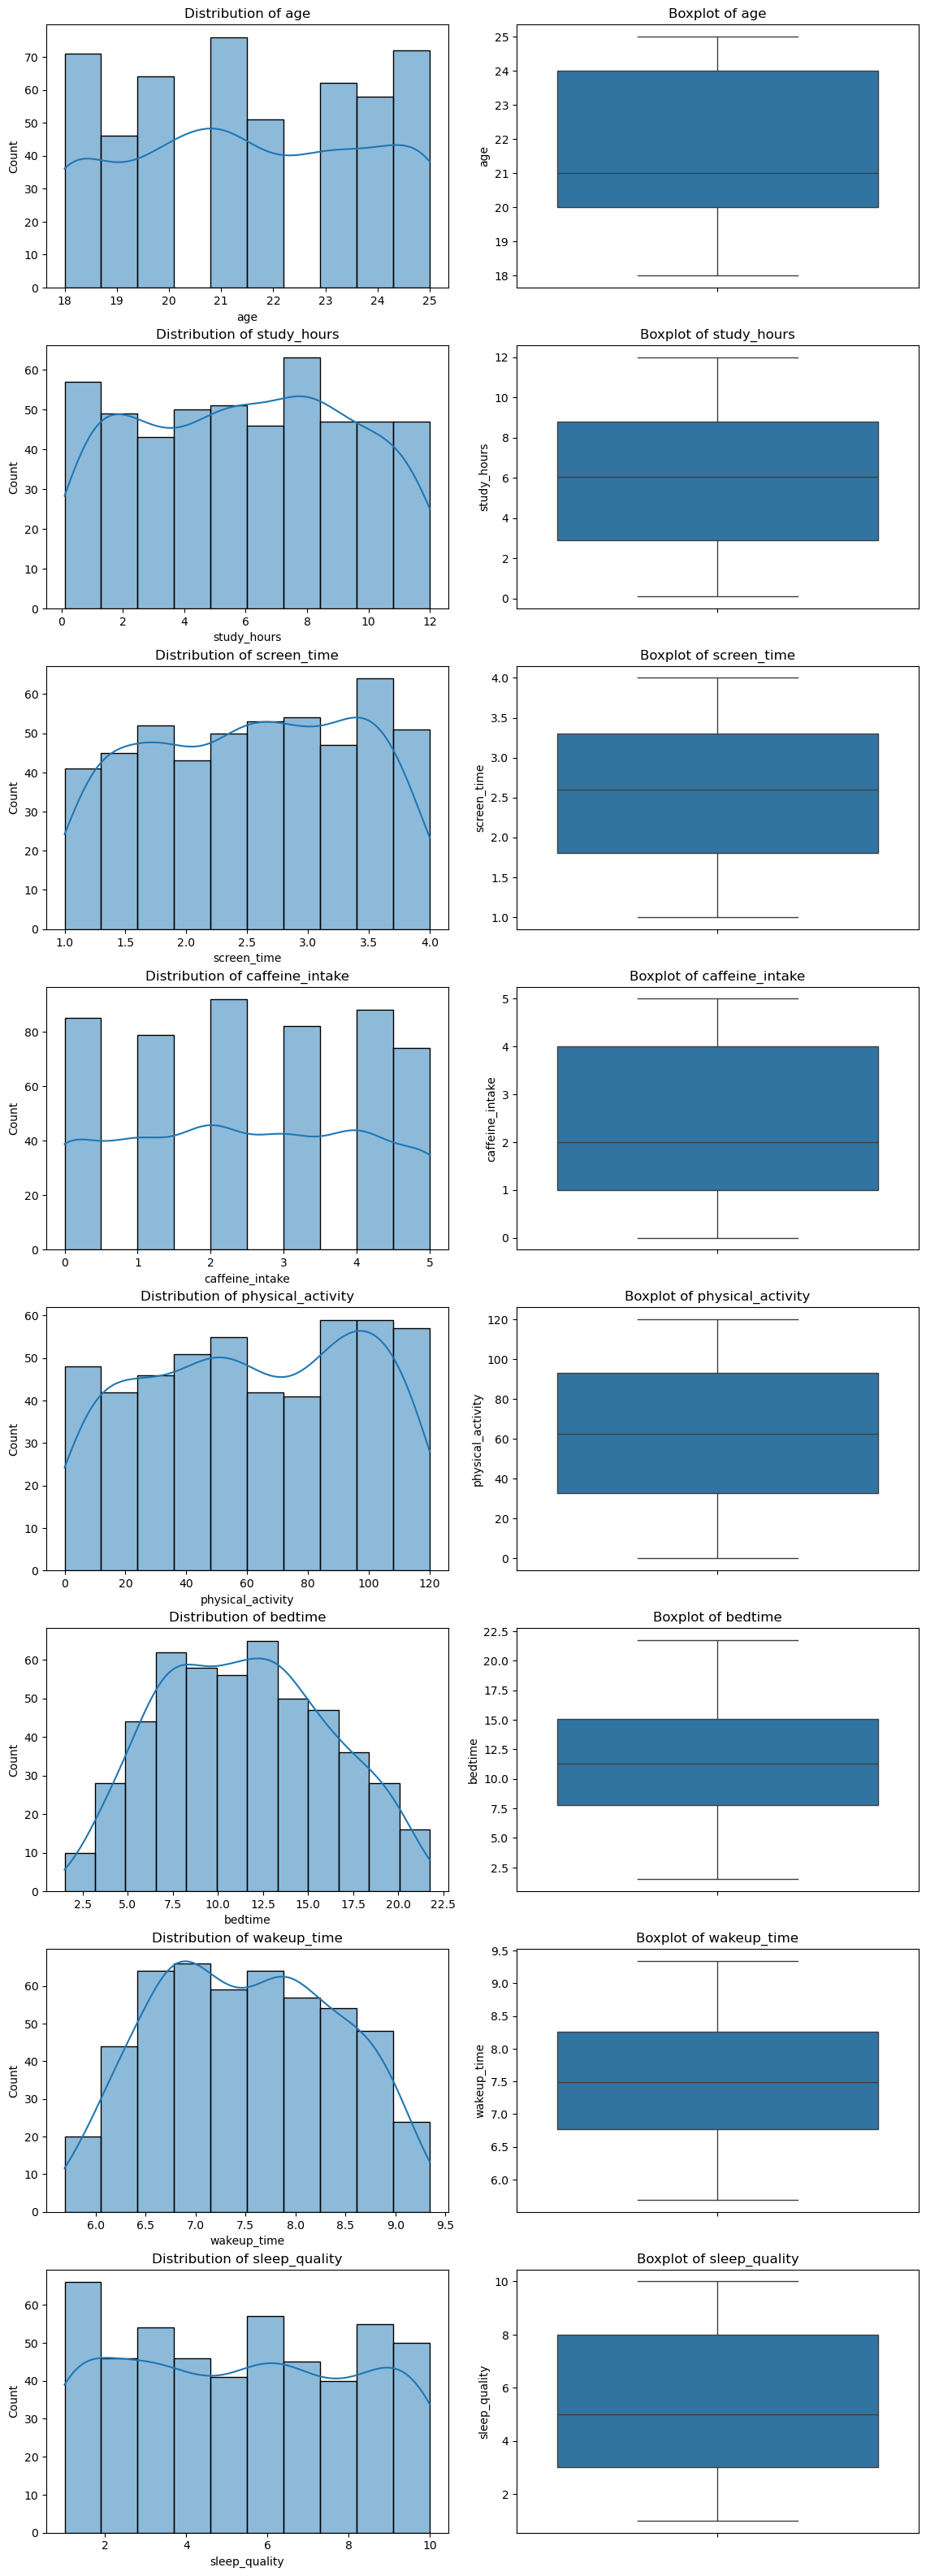

In [32]:
# histograms

# create a figure with subplots for all numerical columns
fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(12, 4*len(numerical_columns)))
fig.tight_layout(pad=3.0)

# plot histograms and box plots for each numerical column
for idx, col in enumerate(numerical_columns):
    # histogram with KDE
    sns.histplot(data=data_main, x=col, kde=True, ax=axes[idx, 0])
    axes[idx, 0].set_title(f'Distribution of {col}')
    
    # box plot
    sns.boxplot(data=data_main, y=col, ax=axes[idx, 1])
    axes[idx, 1].set_title(f'Boxplot of {col}')

plt.show()

While most data here is indeed approximately symmetrical, it is not normal.
The distributions often have a peak at the mean, but no real tails.
The features `age` and `caffeine_intake` are almost uniformly distributed.

The only features that are close to being normally distributed are bedtime and
wakeup time.

Also, there are no outliers.
This makes normalization the better choice here.

Also the label `sleep_quality` is rather uniformly distributed.

### Scale Numerical Data

In [33]:
# create scaler
scaler = MinMaxScaler()

# apply normalization
data_main[numerical_columns] = scaler.fit_transform(
    data_main[numerical_columns]
)

data_main

,age,study_hours,screen_time,caffeine_intake,physical_activity,bedtime,wakeup_time,sleep_quality,gender_female,gender_male,gender_other,university_year_1st_Year,university_year_2nd_Year,university_year_3rd_Year,university_year_4th_Year
0,0.857143,0.655462,0.800000,0.4,0.308333,0.482257,0.443706,1.000000,0,0,1,0,1,0,0
1,0.428571,0.495798,0.300000,1.0,0.616667,0.333757,0.846364,0.111111,0,1,0,1,0,0,0
2,0.571429,0.554622,0.966667,1.0,0.441667,0.919929,0.641908,0.444444,0,1,0,0,0,0,1
3,0.857143,0.714286,0.600000,0.8,0.458333,0.682328,0.487490,0.888889,0,0,1,0,0,0,1
4,0.285714,0.218487,0.566667,0.0,0.708333,0.752028,0.903049,0.222222,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.857143,0.773109,0.300000,0.8,0.916667,0.659048,0.640735,0.333333,0,1,0,0,1,0,0
496,0.285714,0.638655,0.833333,0.6,0.333333,0.187937,0.152072,0.333333,0,1,0,0,1,0,0
497,0.428571,0.529412,0.966667,0.2,0.566667,0.308007,0.348710,1.000000,0,1,0,0,0,1,0
498,0.000000,0.033613,0.833333,0.0,0.100000,0.817919,0.638389,0.111111,1,0,0,0,1,0,0


In [34]:
# relocate the label column to the end of the data set
data_main = data_main[
    [col for col in data_main.columns if col != "sleep_quality"] + ["sleep_quality"]
]

data_main

,age,study_hours,screen_time,caffeine_intake,physical_activity,bedtime,wakeup_time,gender_female,gender_male,gender_other,university_year_1st_Year,university_year_2nd_Year,university_year_3rd_Year,university_year_4th_Year,sleep_quality
0,0.857143,0.655462,0.800000,0.4,0.308333,0.482257,0.443706,0,0,1,0,1,0,0,1.000000
1,0.428571,0.495798,0.300000,1.0,0.616667,0.333757,0.846364,0,1,0,1,0,0,0,0.111111
2,0.571429,0.554622,0.966667,1.0,0.441667,0.919929,0.641908,0,1,0,0,0,0,1,0.444444
3,0.857143,0.714286,0.600000,0.8,0.458333,0.682328,0.487490,0,0,1,0,0,0,1,0.888889
4,0.285714,0.218487,0.566667,0.0,0.708333,0.752028,0.903049,0,1,0,0,0,0,1,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.857143,0.773109,0.300000,0.8,0.916667,0.659048,0.640735,0,1,0,0,1,0,0,0.333333
496,0.285714,0.638655,0.833333,0.6,0.333333,0.187937,0.152072,0,1,0,0,1,0,0,0.333333
497,0.428571,0.529412,0.966667,0.2,0.566667,0.308007,0.348710,0,1,0,0,0,1,0,1.000000
498,0.000000,0.033613,0.833333,0.0,0.100000,0.817919,0.638389,1,0,0,0,1,0,0,0.111111


The main data set is now prepared for analysis.
What's left to do is to prepare feature and label data sets as well as to split
it between train, val and test sets.

In [35]:
# save this version to the intermediate data directory
# it is already transformed, but the final version is the split one
data_main.to_csv(
    PATH_DATA_INTERMEDIATE_DIR / "sleep_data_main_intermediate.csv",
    index=False
)

In [36]:
# split and write the data using the function defined at the beginning
split_write_data(
    data=data_main,
    label_column="sleep_quality",
    output_dir=PATH_DATA_MAIN_PROCESSED_DIR,
    filename_prefix="sleep_data_main"
)

In [37]:
data_main

,age,study_hours,screen_time,caffeine_intake,physical_activity,bedtime,wakeup_time,gender_female,gender_male,gender_other,university_year_1st_Year,university_year_2nd_Year,university_year_3rd_Year,university_year_4th_Year,sleep_quality
0,0.857143,0.655462,0.800000,0.4,0.308333,0.482257,0.443706,0,0,1,0,1,0,0,1.000000
1,0.428571,0.495798,0.300000,1.0,0.616667,0.333757,0.846364,0,1,0,1,0,0,0,0.111111
2,0.571429,0.554622,0.966667,1.0,0.441667,0.919929,0.641908,0,1,0,0,0,0,1,0.444444
3,0.857143,0.714286,0.600000,0.8,0.458333,0.682328,0.487490,0,0,1,0,0,0,1,0.888889
4,0.285714,0.218487,0.566667,0.0,0.708333,0.752028,0.903049,0,1,0,0,0,0,1,0.222222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.857143,0.773109,0.300000,0.8,0.916667,0.659048,0.640735,0,1,0,0,1,0,0,0.333333
496,0.285714,0.638655,0.833333,0.6,0.333333,0.187937,0.152072,0,1,0,0,1,0,0,0.333333
497,0.428571,0.529412,0.966667,0.2,0.566667,0.308007,0.348710,0,1,0,0,0,1,0,1.000000
498,0.000000,0.033613,0.833333,0.0,0.100000,0.817919,0.638389,1,0,0,0,1,0,0,0.111111


In [38]:
# transform remaining datasets using function defined at beginning of notebook
df_wearable_tech_sleep_quality_selected = transform_dataset(
    df_wearable_tech_sleep_quality_selected,
    "sleep_quality_score"
)

df_wearable_tech_sleep_quality_selected

,caffeine_intake_mg,stress_level,light_exposure_hours,sleep_quality_score
0,0.269060,0.277184,0.527254,0.000000
1,0.261646,0.373814,0.462017,0.000000
2,0.000000,0.311588,0.507937,1.000000
3,0.292477,0.390401,0.630907,0.000000
4,0.558207,0.457170,0.708967,0.000000
...,...,...,...,...
995,0.417867,0.440427,0.545920,0.000000
996,0.663162,0.653806,0.693630,0.000000
997,0.070649,0.394522,0.752020,0.827250
998,0.491988,0.498979,0.436880,0.000000


In [39]:
df_sleep_efficiency_selected = transform_dataset(
    df_sleep_efficiency_selected,
    "sleep_efficiency"
)

df_sleep_efficiency_selected

,age,caffeine_consumption,alcohol_consumption,exercise_frequency,bedtime,wakeup_time,gender_Female,gender_Male,smoking_status_No,smoking_status_Yes,sleep_efficiency
0,0.933333,0.000,0.0,0.6,0.043478,0.421053,1.0,0.0,0.0,1.0,0.775510
1,1.000000,0.000,0.6,0.6,0.086957,0.631579,0.0,1.0,0.0,1.0,0.326531
2,0.516667,0.000,0.0,0.6,0.934783,0.263158,1.0,0.0,1.0,0.0,0.795918
3,0.516667,0.250,1.0,0.2,0.108696,0.578947,1.0,0.0,0.0,1.0,0.020408
4,0.800000,0.000,0.6,0.6,0.043478,0.631579,0.0,1.0,1.0,0.0,0.530612
...,...,...,...,...,...,...,...,...,...,...,...
447,0.300000,0.000,0.0,1.0,0.956522,0.263158,1.0,0.0,1.0,0.0,0.836735
448,0.716667,0.125,0.0,0.6,0.913043,0.000000,0.0,1.0,1.0,0.0,0.489796
449,0.516667,0.075,0.6,0.0,1.000000,0.473684,1.0,0.0,0.0,1.0,0.102041
450,0.600000,0.000,0.0,0.6,0.913043,0.105263,0.0,1.0,1.0,0.0,0.530612


In [40]:
df_sleep_health_and_lifestyle = transform_dataset(
    df_sleep_health_and_lifestyle,
    "quality_of_sleep"
)

df_sleep_health_and_lifestyle

,age,physical_activity_level,stress_level,daily_steps,gender_female,gender_male,occupation_accountant,occupation_doctor,occupation_engineer,occupation_lawyer,...,occupation_software_engineer,occupation_teacher,bmi_category_normal,bmi_category_normal_weight,bmi_category_obese,bmi_category_overweight,sleep_disorder_insomnia,sleep_disorder_none,sleep_disorder_sleep_apnea,quality_of_sleep
0,0.00000,0.20,0.6,0.171429,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.4
1,0.03125,0.50,1.0,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.4
2,0.03125,0.50,1.0,1.000000,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.4
3,0.03125,0.00,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0.03125,0.00,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,1.00000,0.75,0.0,0.571429,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
370,1.00000,0.75,0.0,0.571429,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
371,1.00000,0.75,0.0,0.571429,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
372,1.00000,0.75,0.0,0.571429,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


Now, all individual data sets are prepared.
They are not joined, however.
The next task is to identify columns that can be joined into the same one.
These need to be renamed in the additional data sets to match the name in the
main data set.
In some cases, like age or gender, that's not even necessary.
In other cases, it needs to be done, but it's kind of clear.
For example: caffeine_intake (main) and caffeine_intake_mg (additional).
Both is in milligrams, so there is no issue here.
In a few cases, I have to consider if it will be possible.
For example physical_activity (main) and physical_activity_level (additional).
They are not necessarily the same, but I scaled it.
Perhaps this may make it work. I will see during training and evaluation.
More risky cases include adding exercise_frequency to this as well.
Finally, there are columns that just don't have a match and need to be
introduced as new columns. This will also introduce missing values.
It's not clear yet if all this yields any improvements in performance, but it
will be interesting to see.